# `Занятие 1.1: Основы Pytorch`

#### `Сириус, смена "Алгоритмы и анализ данных" 2024`

#### `Алексеев Илья, ММП ВМК МГУ`

#### `За основу взяты материалы Находнова Максима`

- https://github.com/mmp-practicum-team/mmp_practicum_fall_2024/tree/main/Seminars/03-numpy
- https://github.com/mmp-practicum-team/mmp_practicum_spring_2024/tree/main/Seminars/Seminar%2003

О чём можно узнать из этого ноутбука:

* операции при работе с массивами (тензорами)
* многомерные массивы
* работа с GPU

Официальная документация:
- https://pytorch.org/

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Наивная работа с матрицами в Python

### `Представление матрицы в Python`

Простейший вариант - список списков:

In [2]:
A = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
]

B = [
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 3],
]

def print_matrix(A):
    for row in A:
        print(row)
    print()

print_matrix(A)
print_matrix(B)

[1, 2, 3]
[4, 5, 6]
[7, 8, 9]

[1, 0, 0]
[0, 2, 0]
[0, 0, 3]



### `Представление матрицы в Python`

Одна из проблем списков — отсутствие поэлементных и матричных операций.

Другой недостаток — работа со списками не позволяет использовать векторные инструкции в процессоре, которые на порядки ускоряют матричные вычисления

Попробуем самостоятельно реализовать несколько методов для матричных вычислений, работающих с представлением матриц в виде списков.

Для оценки производительности будем использовать *декооратор* `timed`:

In [3]:
from time import perf_counter

def timed(method):
    def __timed(*args, **kw):
        time_start = perf_counter()
        result = method(*args, **kw)
        time_end = perf_counter()
        print('{}  {:.3f} ms\n'.format(method.__name__,
                                      (time_end - time_start) * 1000))
        return result

    return __timed

### `Опишем базовые операции: транспонирование`

Для матрицы $A\in\text{Mat}(m\times n)$:
$$
C_{ij} := A_{ji}
$$

In [4]:
@timed
def matrix_transpose(A):
    m, n = len(A), len(A[0])
    C = [[0] * n for _ in range(m)]
    for i in range(m):
      for j in range(n):
        C[i][j] = A[i][j]
    return C

print_matrix(matrix_transpose(A))

matrix_transpose  0.009 ms

[1, 2, 3]
[4, 5, 6]
[7, 8, 9]



### `Опишем базовые операции: сложение`

Для матриц одинакового размера $A,B\in\text{Mat}(m\times n)$:

$$
C_{ij}:=A_{ij}+B_{ij}
$$

In [5]:
@timed
def matrix_add(A, B):
    # skip correctness of dimensions check

    n, m = len(A), len(A[0])
    C = [[0.0 for _ in range(m)] for _ in range(n)]

    for i in range(n):
        for j in range(m):
            C[i][j] = A[i][j] + B[i][j]
    return C

print_matrix(matrix_add(A, B))

matrix_add  0.013 ms

[2, 2, 3]
[4, 7, 6]
[7, 8, 12]



### `Опишем базовые операции: умножение`

Для матрицы $A\in\text{Mat}(m\times n)$, $B\in\text{Mat}(n\times m)$:
$$
C_{ij}=\sum_{r=1}^n A_{ir}B_{rj}
$$

Анимированный пример:

![mm_gif](https://notesbylex.com/_media/matrix-multiplication.gif)

In [6]:
def dot(a, b):
    return sum(x * y for (x, y) in zip(a, b))

@timed
def matrix_mul(A, B):
    # check correctness of dimensions
    n, m = len(A), len(B[0])
    C = [[0.0 for _ in range(n)] for _ in range(m)]

    B_T = matrix_transpose(B)
    for i in range(n):
        for j in range(m):
            C[i][j] = dot(A[i], B_T[j])
    return C

print_matrix(matrix_mul(A, B))

matrix_transpose  0.008 ms

matrix_mul  0.087 ms

[1, 4, 9]
[4, 10, 18]
[7, 16, 27]



## `Базовая работа с тензорвами в PyTorch`

- Позволяет работать с многомерными массивами (**тензорами**)
- Реализует множество базовых матричных операций
- Работает на порядки быстрее самописных реализаций в Python

In [7]:
import torch

### `Почему torch быстрый`

- Значительная часть кода написана на C++ и CUDA

- Базовым классом является `Tensor`, имеющий следующие отличия от списков:
    1. Имеет фиксированную длину, задаваемую в момент его создания (списки в Python могут менять размер динамически)
    2. Все элементы в NumPy array имеют один тип
- PyTorch поддерживает ускорение с помощью GPU, что позволяет использовать возможности параллельной обработки. Это может привести к ускорению обучения и использования моделей глубокого обучения на порядок
- И миллион других причин


### `Способы создания torch.Tensor`

1. Из списка списков
2. Пустой
3. Заполненный нулями
4. Заполненный единицами
5. Заполненный нужным значением

In [8]:
a = torch.tensor([[1, 2, 3], [4, 5, 6]])
a

tensor([[1, 2, 3],
        [4, 5, 6]])

In [9]:
a.shape

torch.Size([2, 3])

In [10]:
torch.empty([2, 3])

tensor([[ 2.8026e-44,  3.2230e-44, -5.1851e-26],
        [ 3.1689e-41,  1.5638e-42,  0.0000e+00]])

In [11]:
torch.zeros([2, 3])

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [12]:
torch.ones([2, 3])

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [13]:
torch.full([2, 3], fill_value=3.0)

tensor([[3., 3., 3.],
        [3., 3., 3.]])

Некорректные входные данные приведут к ошибке:

In [14]:
torch.tensor([[1, 2, 3], [4, 6]])

ValueError: expected sequence of length 3 at dim 1 (got 2)

In [15]:
# Синтаксис аналогичен built-in функции `range`
torch.arange(2, 10)

tensor([2, 3, 4, 5, 6, 7, 8, 9])

### `Способы создания torch.Tensor`

**Задача.** Задайте массив `result` размером $50$ на $30$, состоящий из троек

In [16]:
### your code here

**Задача.** Какая размерность будет у массива, полученного с помощью команды `torch.tensor([[1], [2]])`?

### `Арифметические операции`

- Арифметические операции в общем случае по-элементные и требуют одинакового размера операндов<br>

- Но torch может применять их к операндам разного размера с помощью broadcasting, то есть правил обработки операндов разного размера<br><br>

Примеры операций с массивами одного размера:

In [17]:
a = torch.tensor(A)
a

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [18]:
a * 2

tensor([[ 2,  4,  6],
        [ 8, 10, 12],
        [14, 16, 18]])

In [19]:
b = torch.tensor(B)
b

tensor([[1, 0, 0],
        [0, 2, 0],
        [0, 0, 3]])

In [20]:
a + b

tensor([[ 2,  2,  3],
        [ 4,  7,  6],
        [ 7,  8, 12]])

### `Поэлементные арифметические операции`

In [21]:
torch.sin(a)

tensor([[ 0.8415,  0.9093,  0.1411],
        [-0.7568, -0.9589, -0.2794],
        [ 0.6570,  0.9894,  0.4121]])

In [22]:
torch.sigmoid(a)

tensor([[0.7311, 0.8808, 0.9526],
        [0.9820, 0.9933, 0.9975],
        [0.9991, 0.9997, 0.9999]])

In [23]:
a ** 0.5

tensor([[1.0000, 1.4142, 1.7321],
        [2.0000, 2.2361, 2.4495],
        [2.6458, 2.8284, 3.0000]])

Поэлементые операции сравнения:

In [24]:
a > 3

tensor([[False, False, False],
        [ True,  True,  True],
        [ True,  True,  True]])

In [25]:
c = torch.arange(12).reshape(3,4)
c[c > 5] = 0
c

tensor([[0, 1, 2, 3],
        [4, 5, 0, 0],
        [0, 0, 0, 0]])

### `Матричные арифметические операции`

In [26]:
print(a - b)

tensor([[0, 2, 3],
        [4, 3, 6],
        [7, 8, 6]])


In [27]:
print(a * b)

tensor([[ 1,  0,  0],
        [ 0, 10,  0],
        [ 0,  0, 27]])


In [28]:
print(b / a)

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.4000, 0.0000],
        [0.0000, 0.0000, 0.3333]])


### `Матричное умножение`

Расмотрим для случая двумерных матриц

In [29]:
print(a @ b, '\n')
print(torch.mm(a, b))
print(torch.matmul(a, b))

tensor([[ 1,  4,  9],
        [ 4, 10, 18],
        [ 7, 16, 27]]) 

tensor([[ 1,  4,  9],
        [ 4, 10, 18],
        [ 7, 16, 27]])
tensor([[ 1,  4,  9],
        [ 4, 10, 18],
        [ 7, 16, 27]])


### `Транспонирование`

- Расмотрим для случая двумерных матриц, кому интересны многомерные, изучайте
https://stackoverflow.com/questions/32034237/how-does-numpys-transpose-method-permute-the-axes-of-an-array
- При транспонировании (как и `reshape`) возвращается ссылка на те же данные

In [30]:
print(a, '\n\n', a.T)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]) 

 tensor([[1, 4, 7],
        [2, 5, 8],
        [3, 6, 9]])


### `Сравнение скорости`

Воспользуемся декоратором `timed` для сравнения скорости матричных операций, реализованных в `torch` и самостоятельно:

In [31]:
@timed
def matrix_add_np(A, B): return A + B

@timed
def matrix_mul_np(A, B): return A @ B

In [32]:
tmp = [range(1000) for _ in range(1000)]
X, Y = torch.tensor(tmp), torch.tensor(tmp)

_ = matrix_add(X, Y)
_ = matrix_add_np(X, Y)

tmp = [range(200) for _ in range(200)]
X, Y = torch.tensor(tmp), torch.tensor(tmp)

_ = matrix_mul(X, Y)
_ = matrix_mul_np(X, Y)

matrix_add  14355.076 ms

matrix_add_np  5.409 ms

matrix_transpose  139.585 ms

matrix_mul  49526.197 ms

matrix_mul_np  15.752 ms



## `Работа с GPU`

Копирование на девайс:

In [33]:
a = torch.tensor([range(1000) for _ in range(1000)])
a_gpu = a.cuda()

In [34]:
a.device

device(type='cpu')

In [35]:
a_gpu.device

device(type='cuda', index=0)

Огромный прирост скорости:

In [36]:
tmp = [range(1000) for _ in range(1000)]
X, Y = torch.tensor(tmp), torch.tensor(tmp)

_ = matrix_add_np(X, Y)

X_gpu, Y_gpu = X.cuda(), Y.cuda()
_ = matrix_add_np(X_gpu, Y_gpu)

matrix_add_np  2.495 ms

matrix_add_np  43.926 ms



Правила работы:
- тензоры, участвующие в одной операции, должны находиться на одном устройстве (оба на CPU / оба на GPU)
- при вызове `.cuda()` данные копируются, причем не мгновенно

In [37]:
X + X_gpu

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [38]:
X = torch.arange(1280000).reshape(10,-1)

start = perf_counter()
X.cuda().cpu().cuda().cpu()
print(perf_counter() - start)

0.012777309000000514


## `Autograd`

### `Интро`

Все тензоры содержат атрибут `.grad`, который может хранить градиент по этому тензору.

In [39]:
X.grad

По умолчанию, тензоры, создаваемые в pytorch, не будут требовать, чтобы для них посчитали градиент. Для этого надо добавить дополнительный аргумент `requires_grad=True`, либо вызвав метод `.requires_grad_()`.

In [40]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = torch.tensor([1., 2., 3.], requires_grad=True)

Производя операции с переменными, по которым нужно считать градиенты, мы конструируем граф вычислений:

In [41]:
z = (3 * x**3 - y**2).sum()
z.requires_grad

True

В каждой переменной есть информация о том, как именно она была получена при проходе вперёд. Исходя из этой информации у тензоров в графе вычислений хранятся функции, которые должны быть вызваны на обратном проходе для расчёта градиента.

In [42]:
z.grad_fn

Для примера сделаем из тензора `z` скаляр, сложив все его элементы, и посчитаем градиенты с помощью функции .backward()

In [43]:
z.backward()

In [44]:
x.grad, y.grad

(tensor([ 9., 36., 81.]), tensor([-2., -4., -6.]))

Сравним с посчитанным вручную градиентом:

In [45]:
torch.allclose(x.grad, 9 * x**2)

True

### `Визуализация графа вычислений`

Для примера визуализируем, как бы выглядел граф вычислений для линейной регресси.

Заметим, что пакет визуализации `pytorchviz` предназначен в первую очередь для визуализации нейронных сетей, поэтому нам необходимо будет использовать класс `torch.nn.Parameter`, который является обёрткой над тензором и несколько расширяет возможности аргумента `requires_grad=True`

Графы визуализируются библиотекой `graphviz`.

In [46]:
! pip3 install torchviz

In [47]:
from torchviz import make_dot

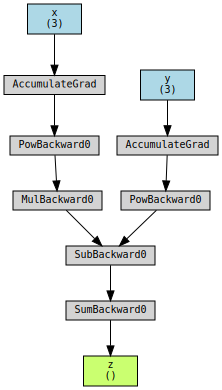

In [48]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = torch.tensor([1., 2., 3.], requires_grad=True)
z = (3 * x**3 - y**2).sum()
make_dot(z, params={'x': x, 'y': y, 'z': z})

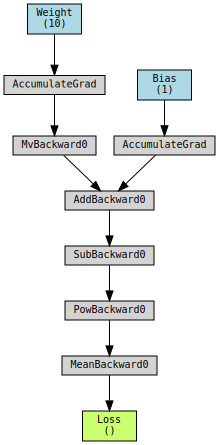

In [49]:
X = torch.rand(5, 10)
y = torch.rand(5)

w = torch.rand(10, requires_grad=True)
b = torch.rand(1, requires_grad=True)

y_hat = X @ w + b

loss = torch.mean((y - y_hat)**2)
make_dot(loss, params={'Weight': w, 'Bias': b, 'Loss': loss})

Что можно сказать об этом графе вычислений?

* В листьях графа мы не видим тензора `X`, так кка нам требуется расчёт градиента только по параметрам модели.
* `MvBackward0` соответствует матрично-векторному умножению (отсюда и первые буквы `Mv`) c матрицей `X`.
* `AddBackward0` соответствует добавлению смещения `b`, остальная часть графа — вычисление MSE.

### `Менеджеры контекста`

Поведением градиента сразу группы тензоров можно управлять с помощью специальных функций, которые вызываются через стандартную семантику питона `with foo():`, где `foo` — одна из трёх функций ниже:

**Default Mode**

Стандартный режим работы pytorch, в котором управление градиентами происходит через requires_grad. Явно его нужно вызывать только внутри других контекстных менеджеров, чтобы временно снова активировать расчёт градиентов (что случается крайне редко) вызовом `torch.enable_grad()`.

**No grad mode**

Данный режим используется когда блока кода нет необходимости вычислять градиенты, что занимает как вычислительные ресурсы, так и дополнительную память. Реализуется вызовом `torch.no_grad()`.

**Inference mode**

Аналогично No grad mode отключает расчёт градиентов, но кроме того проводит дополнительные оптимизации, что делает вычисления внутри блока кода ещё быстрее. Однако, тензоры, созданные в таком блоке будет невозможно использовать совместно с тензорами, для которых расчёт градиента необходим. Реализуется вызовом `torch.inference_mode()`.

In [50]:
x = torch.rand(3, requires_grad=True)

with torch.no_grad():
    y = x + x

y.requires_grad

False

In [51]:
@torch.no_grad()
def foo(x):
    return x + 2

y = foo(x)
y.requires_grad

False